# StanFitter demo: Normal mean estimation

This notebook performs a Stan fit to simulated data from a normal distribution,
estimating the mean with a normal prior/normal sampling dist'n model.  It prints
summaries of the posterior to the terminal, and plots two figures showing
traceplots (of the posterior mean and the log density) and an estimated
posterior PDF (blue curve) along with the analytical PDF (green dashed curve).

This notebook uses StanFitter, a module that wraps PyStan to make it
more "Pythonic" to use.

Three statistical tests are run, with results printed to the terminal.  They
will occasionally fail even with a sound installation, but this should happen
only rarely.

**Windows users:**  This example presumes Windows users are using
PyStan-2.19+ with Py-3.  Earlier versions did not support parallel
computing (running separate chains in separate jobs), and PyStan-2.19
only supports parallel computing with Py-3 (and presently this support
appears to be unreliable).

I strongly recommend using conda to install a current Anaconda Python-3
environment, with PyStan installed via `conda install pystan` (i.e., not using
the `pip` installer recommended in PyStan's documentation).  This will
install a version of the C++ compiler needed by PyStan, and ensure it is
compatible with conda's Python installation.

Created Apr 16, 2015 by Tom Loredo<br>
2018-01-02:  Modified for Python 3<br>
2020-04-16:  Minor mods to docs & code for BDA20; convert to Jupyter notebook

In [1]:
from IPython.display import Audio, display  # for audio alert

import numpy as np
import scipy
import matplotlib as mpl
from matplotlib.pyplot import *
from numpy import *
from scipy import stats

import arviz as az  # an MCMC output analysis package

from stanfitter import StanFitter
from timer import Timer


ion()

In [2]:
def done_alert():
    "Play an audio file as an alert."
    # From: https://forums.fast.ai/t/sound-alerts-in-jupyter-for-code-completion-and-exceptions/4614
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

## Simulate data

Setup a "true" data generation model (i.e., sampling distribution) and simulate data from it.

In [3]:
# Sampling dist'n for data from a unit-sigma normal @ mu:
mu = 5.
samp_distn = stats.norm(mu, 1.)

# Simulate data:
N = 100
yvals = samp_distn.rvs(N)

## Analytical posterior

Compute the analytical posterior for a conjugate normal-normal model, for comparison with Stan's MCMC results.

In [4]:
mu0 = 0.  # prior mean
w0 = 10.  # prior width
w = 1./sqrt(N)  # likelihood width
ybar = mean(yvals)  # likelihood location
B = w**2/(w**2 + w0**2)  # shrinkage factor
mu_post = ybar + B*(mu0 - ybar)
sig_post = w*sqrt(1.-B)
post = stats.norm(mu_post, sig_post)

mu_l, mu_u = mu_post - 4.*sig_post, mu_post + 4.*sig_post
mu_vals = linspace(mu_l, mu_u, 300)
pdf_vals = post.pdf(mu_vals)

## Stan code

Stan code for a conjugate normal-normal model with unknown mean:

In [5]:
normal_mu_code = """
data {
    int<lower=0> N; // number of samples
    real y[N]; // samples
}

parameters {
    real mu;
}

model {
    mu ~ normal(0, 10.);  // prior is a wide normal
    for (i in 1:N) {
        y[i] ~ normal(mu, 1.);  // sampling dist'n
    }
}
"""

## Build and deploy the model using StanFitter

**Create a StanFitter instance:** This invokes Stan to compile the model, caching the built model in the CWD to avoid recompilation if the script is re-run without any Stan code changes.

This is a bit time-consuming (which can make debugging somewhat painful). Here, we do the compilation using a `Timer` context manager provided in the [`timer` module](./timer.py). For more on context managers and Python's `with` statement, see [The `with` statement — Python 3.8.2 documentation](https://docs.python.org/3/reference/compound_stmts.html#the-with-statement) and [a `with` statement tutorial](https://www.pythonforbeginners.com/files/with-statement-in-python).

*NOTE:* Watch the terminal running the notebook server, both when compiling Stan code and later, when using the resulting Stan model to fit data. Stan prints some information to the terminal, including compilation errors and sampling progress.

In [6]:
with Timer(quiet=False) as timer:
    # The `name` parameter is optional; it is used to name the file
    # holding the cached code (a Python pickle file).
    fitter = StanFitter(normal_mu_code, name='NormNorm')

# Alternatively, the Stan code can be in a separate .stan file:
#fitter = StanFitter('NormalNormal.stan', name='NormNorm')

Using cached StanModel from cached-model-NormNorm-cef235655b651e746303ed6d9109c782.pkl...
-> Elapsed time = 25.304697 ms
Task completed!


**Provide data:**

Stan requires a dictionary providing the data.

In [7]:
normal_mu_data = {'N': N, 'y': yvals}

The data could have been provided to the `StanFitter` object, for convenience. The set_data() method enables using the same model to fit multiple datasets.

In [8]:
fitter.set_data(normal_mu_data)

**Posterior sampling:** Run 4 chains of 1000 iters. By default Stan will discard the first half of each sample path as "warmup" or "burn-in," so this run will produce 2k samples.

The fitter returns a `StanFitResults` instance, whose attributes provide access to the fit results.

In [9]:
fit = fitter.sample(n_iter=10000, n_chains=4)

## Basic output analysis

Print textual summaries for the parameters monitored by Stan (the model
parameter mu, and the log posterior PDF, log_p).  These include basic
(minimal) convergence and mixing diagnostics.

In [10]:
print()
print(fit.mu)
print(fit.log_p)


Parameter <mu> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 7095
Mean (se), median, sd:  4.86 (0.00119),  4.86,  0.1
Central intvls:  50%: [4.79, 4.93];  95%: [4.66, 5.06]

Parameter <log_p> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 9947
Mean (se), median, sd:  -35.18 (0.01),  -34.91,  0.71
Central intvls:  50%: [-35.35, -34.73];  95%: [-37.22, -34.68]



Also check convergence & mixing by examining trace plots,
making sure there are no obvious trends or strong, long-range correlations.
Use each parameter's trace() method to plot the trace on an existing set of
axes, or to create a new figure with the parameter's traceplot.

/Volumes/Science/Education/BDA 2020/Labs/Lab10 - StanFitter/stanfitter.py:181: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  axes.figure.show()  # needed for display update with axes
/Volumes/Science/Education/BDA 2020/Labs/Lab10 - StanFitter/stanfitter.py:181: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  axes.figure.show()  # needed for display update with axes


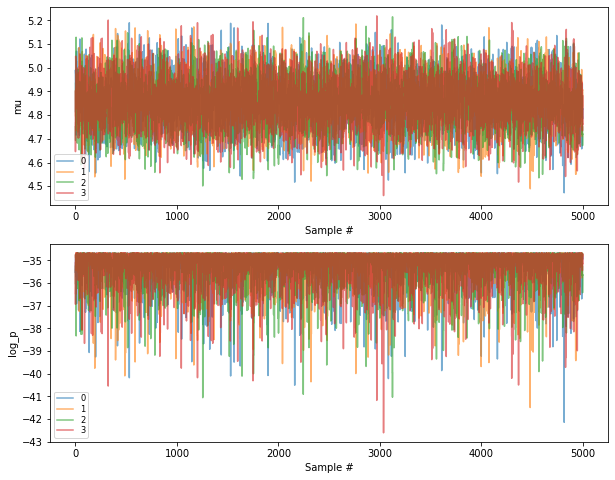

In [11]:
f = figure(figsize=(10,8))
ax = f.add_subplot(2,1,1)
fit.mu.trace(axes=ax,alpha=.6)  # without `axes`, this will make its own fig
ax = f.add_subplot(2,1,2)
fit.log_p.trace(axes=ax,alpha=.6)

Stan's default plot, showing a (marginal) PDF (via KDE) and a merged-chains trace plot:

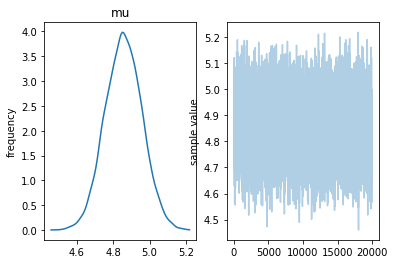

In [12]:
fig = fit.stan_plot()
pdf_ax, trace_ax = fig.get_axes()

Plot the analytical PDF on top of Stan's PDF estimate.

In [13]:
pdf_ax.plot(mu_vals, pdf_vals, 'g--', lw=3, alpha=.7)

## Simple tests

Test cases; note they will sometimes (rarely) fail even for correct<br>
code.  If the 'return' statements are changed to 'assert', these<br>
become valid nose test cases, but nose appears to have issues with PyStan<br>
and/or matplotlib.

In [14]:
def test_post_mean():
    """
    Check that Stan's posterior mean matches the analytical mean to within
    3* the standard error.  This should fail ~< 1% of the time.
    """
    return abs(fit.mu.mean - mu_post)/fit.mu.se_mean < 3.


def test_intvl():
    """
    Check that the true mean is within the 95% interval; this should fail
    5% of the time.
    """
    lo, hi = fit.mu.q025, fit.mu.q975  # quantile attributes
    return (mu > lo) and (mu < hi)


def test_Rhat():
    """
    Test that the chain appears to have converged.  This can fail with
    correct code if the chain was not run long enough.
    """
    return abs(fit.mu.Rhat - 1.) < 0.05  # slightly more strict than 0.1 convention


print('********************************')
print('Test results (should be 3*True):')
print(test_post_mean(), test_intvl(), test_Rhat())
print('********************************\n')

********************************
Test results (should be 3*True):
True True True
********************************



## Output analysis with ArviZ

`StanFitResults` instances have an `azdata` attribute containing a ArviZ `InferenceData` object containing the posterior samples. Methods of this object provide various visualization and diagnostic plots. See [ArviZ: Exploratory analysis of Bayesian models — ArviZ 0.7.0 documentation](https://arviz-devs.github.io/arviz/index.html) for information on what ArviZ can do (see especially the Gallery).

In [15]:
dir(fit.azdata)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_groups',
 'from_netcdf',
 'posterior',
 'sample_stats',
 'sel',
 'to_netcdf']

In [16]:
fit.azdata.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 5000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 4993 4994 4995 4996 4997 4998 4999
Data variables:
    mu       (chain, draw) float64 4.815 4.991 4.977 4.971 ... 4.735 4.884 4.762
Attributes:
    created_at:                 2020-04-17T18:26:08.660567
    inference_library:          pystan
    inference_library_version:  2.19.0.0

In [17]:
fit.azdata.sample_stats

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 5000)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 ... 4994 4995 4996 4997 4998 4999
Data variables:
    accept_stat  (chain, draw) float64 0.9331 0.7937 1.0 ... 0.923 0.9741 0.7023
    stepsize     (chain, draw) float64 1.123 1.123 1.123 ... 1.094 1.094 1.094
    treedepth    (chain, draw) int64 2 1 1 1 2 1 1 1 1 2 ... 2 2 2 1 2 1 1 2 1 2
    n_leapfrog   (chain, draw) int64 3 3 1 1 3 3 1 1 1 3 ... 3 3 3 3 3 3 3 3 3 3
    diverging    (chain, draw) bool False False False ... False False False
    energy       (chain, draw) float64 35.04 35.94 35.68 ... 35.45 35.46 36.61
    lp           (chain, draw) float64 -34.77 -35.55 -35.38 ... -34.71 -35.14
Attributes:
    created_at:                 2020-04-17T18:26:08.672260
    inference_library:          pystan
    inference_library_version:  2.19.0.0

/Users/loredo/anaconda/envs/bda20tk/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/loredo/anaconda/envs/bda20tk/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/loredo/anaconda/envs/bda20tk/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/loredo/anaconda/envs/bda20tk/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs ha

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feeb8c9ce10>,
      dtype=object)

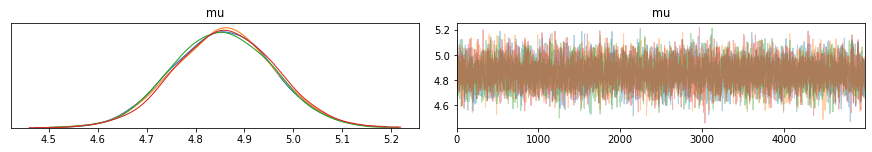

In [18]:
az.plot_trace(fit.azdata, var_names=('mu'))

INFO:numba.transforms:finding looplift candidates


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feeb0c30470>]],
      dtype=object)

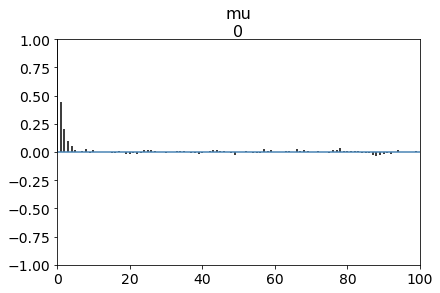

In [19]:
az.plot_autocorr(fit.azdata, var_names=('mu'))

## Exercise — Gamma-Poisson inference

As an exercise, create a new notebook, and follow the pattern of this notebook to:

* Simulate a count from a Poisson distribution with rate `r` over a time interval of duration `T`. (Choose your own values; values with a relatively modest number of expected counts will be the most interesting in the sense of giving a posterior PDF for `r` that is not approximately normal.)
* Create a Stan model to infer `r`, using a gamma distribution for the prior.  Make the prior broad.
* Perform a fit an analyses similar to what you see here, including a plot comparing Stan's posterior (estimate from the posterior samples) and the analytical posterior

Consult the [Stan Documentation](https://mc-stan.org/users/documentation/) for your work. In particular, information about how Stan parameterizes its many available probability distributions is in the [Stan Functions Reference](https://mc-stan.org/docs/2_22/functions-reference/index.html). **_Hint:_** Different computer languages parameterize probability distributions in different ways!